In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor
from src.dbc import utils, TimeDivisionKMeans
import src.utils as ut

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

,name,usage (kWh)
63,아파트1-103-1602,387


In [678]:
households = calc.households

households[month_df[month_df['name'] == '아파트1-103-1602'].index[0]].elec_bill

43420

In [4]:
fee = calc.fee
public_bill = calc.public_bill
public_bill

2640560

In [5]:
_public_bill = public_bill / len(month_df)
_public_bill

24449.62962962963

# 데이터 준비 및 전처리

In [67]:
# Data Preprocessing - Excel Parsing
import datetime as dt

indexes = xlsx.iloc[3:].apply(lambda x: dt.datetime(x[1],
                                         x[2],
                                         x[3],
                                         x[4],
                                         x[5]), axis=1).values
columns = xlsx.iloc[:,7:].apply(lambda x: "{}-{}-{}".format(x[0], x[1], x[2])).values
datas = xlsx.iloc[3:,7:].to_numpy()

df = pd.DataFrame(datas, columns=columns, index=indexes)
df.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2018-05-01 00:00:00,0.085,0.016,0.052,0.003,0.032,0.074,0.053,0.096,0.105,0.042,...,0.098,0.053,0.091,0.08,0.207,0.132,0.039,0.034,0.055,0.075
2018-05-01 00:15:00,0.086,0.049,0.053,0.002,0.022,0.014,0.048,0.09,0.108,0.022,...,0.13,0.048,0.055,0.084,0.14,0.149,0.037,0.032,0.082,0.096
2018-05-01 00:30:00,0.085,0.013,0.073,0.002,0.016,0.051,0.029,0.033,0.097,0.046,...,0.103,0.029,0.08,0.07,0.124,0.116,0.055,0.027,0.05,0.101
2018-05-01 00:45:00,0.085,0.043,0.067,0.002,0.015,0.015,0.031,0.092,0.048,0.067,...,0.041,0.051,0.096,0.14,0.1,0.056,0.03,0.034,0.072,0.092
2018-05-01 01:00:00,0.084,0.033,0.051,0.003,0.022,0.052,0.052,0.03,0.041,0.045,...,0.06,0.063,0.062,0.105,0.073,0.073,0.07,0.026,0.061,0.063


In [76]:
np_m_15 = df.to_numpy().T
np_m_15 = np_m_15.reshape(-1, round(35040 / 4), 4)
np_m_15[0, :5]

np_m_60 = np_m_15.sum(axis=2)
m_60 = pd.DataFrame(np_m_60.T, columns=m_15.columns, index=m_15.index[::4])
m_60 = m_60[m_60.index.month == 1]

m_60.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2019-01-01 00:00:00,0.033,0,0.034,0.037,0.062,0.322,0.24,0.295,0.373,0.243,...,0.534,0.188,0.4,0.318,0.42,0.626,0.484,0.289,0.305,0.652
2019-01-01 01:00:00,0.048,0,0.033,0.037,0.063,0.185,0.257,0.397,0.257,0.228,...,0.396,0.434,0.355,0.25,0.465,0.409,0.459,0.336,0.332,0.557
2019-01-01 02:00:00,0.032,0,0.039,0.036,0.062,0.175,0.384,0.353,0.123,0.141,...,0.194,0.337,0.379,0.274,0.326,0.307,0.405,0.382,0.311,0.491
2019-01-01 03:00:00,0.033,0,0.039,0.037,0.062,0.167,0.276,0.488,0.142,0.159,...,0.286,0.263,0.375,0.264,0.336,0.345,0.298,0.291,0.261,0.511
2019-01-01 04:00:00,0.032,0.001,0.033,0.037,0.063,0.197,0.266,0.278,0.19,0.227,...,0.275,0.245,0.31,0.423,0.36,0.364,0.212,0.347,0.294,0.507


# KMeans Clustering

ECV : 51 %


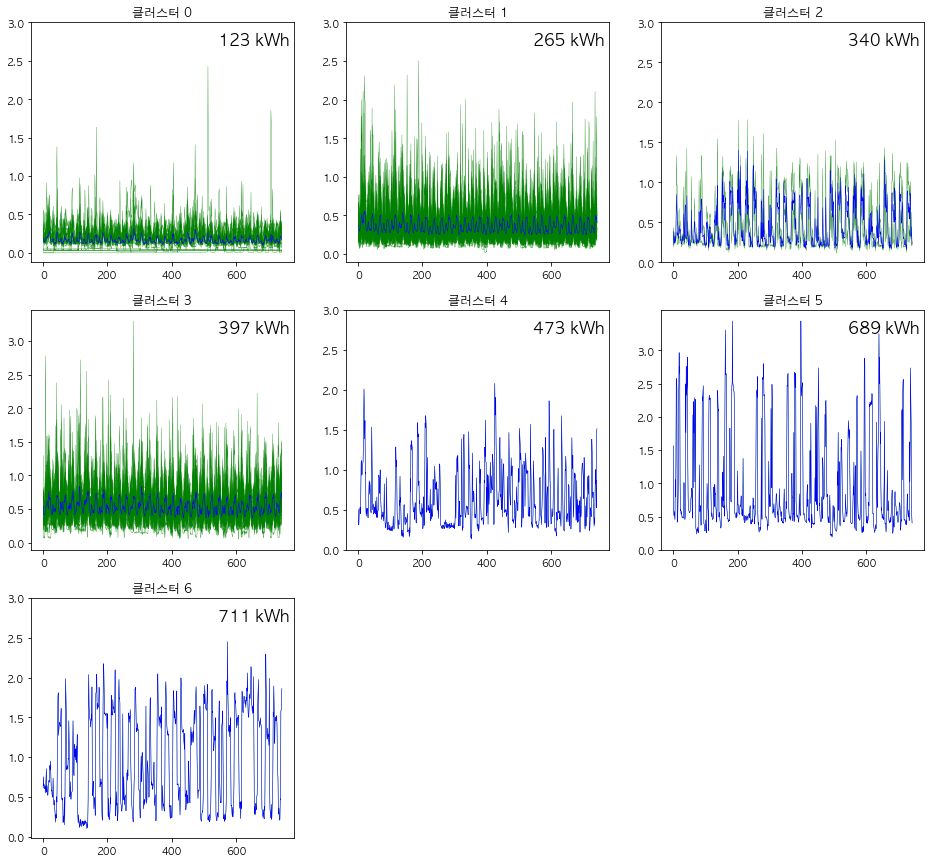

In [82]:
from src.KMeans import KMeans

kmeans = KMeans(datas=m_60.T.values, ver=3)
kmeans.fit()
kmeans.sorting()

kmeans.draw_plot()

# Anomaly 조정작업

In [246]:
group_df = ut.make_group_df(m_60, kmeans)
anomaly_df = ut.get_anomaly_df(group_df)
new_group_df = ut.adjust_anomaly_df(anomaly=anomaly_df,group_df=group_df, datas=m_60)

while True:
    anon_chk = ut.get_anomaly_df(new_group_df)
    
    if len(anon_chk) != 0:
        new_group_df = ut.adjust_anomaly_df(anomaly=anon_chk,group_df=group_df, datas=m_60)
    else: 
        break

KeyError: '가구명'

0.4950151983485789


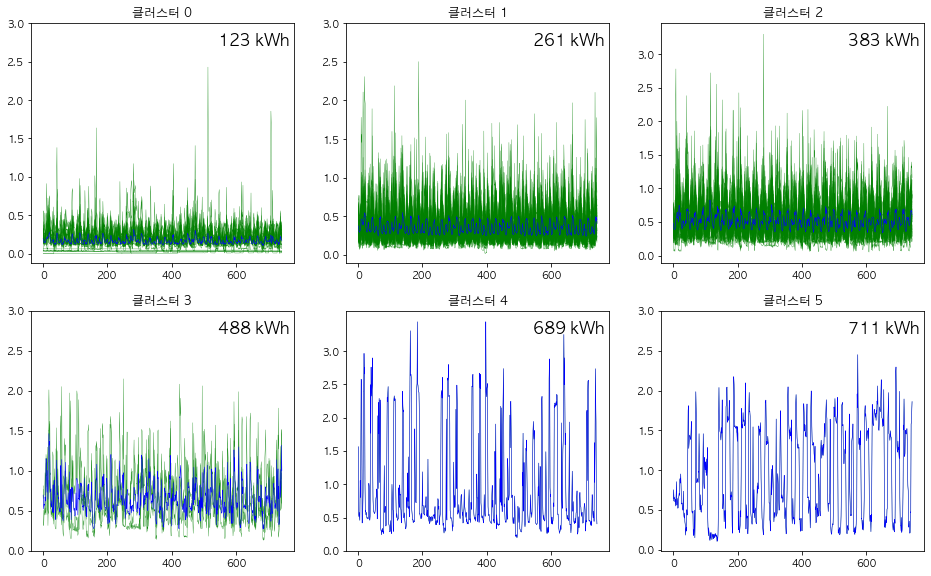

In [104]:
K = new_group_df['label'].value_counts().index.size

kmeans.K = K
kmeans.clusters_ = kmeans.clusters_[:K]
kmeans.labels_ = new_group_df['label'].values

kmeans.next_setting()

print(kmeans.ecv)
kmeans.draw_plot()

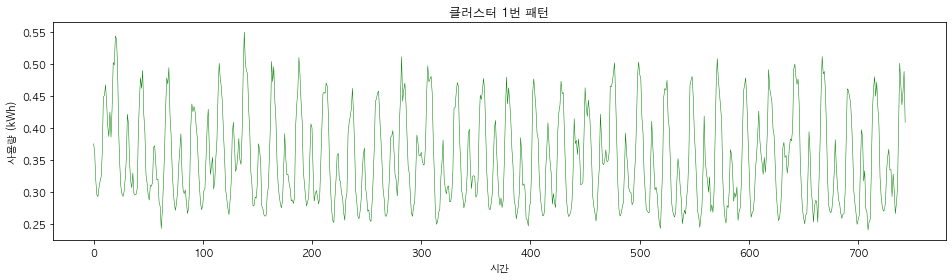

In [322]:
time_clusters = kmeans.clusters_

time_target = time_clusters[1]

plt.figure(figsize=(16, 4))

plt.plot(time_target, color='g', linewidth=0.5)
plt.title("클러스터 1번 패턴")
plt.ylabel("사용량 (kWh)")
plt.xlabel("시간")

plt.show()

In [620]:
clusters = kmeans.clusters_.copy()
time_clusters = list()
mean_time_clusters = list()

for c in clusters:
    time_group = time_grouping(c, 4)
    
    time_clusters.append(time_group)
    mean_time_clusters.append(time_group.mean(axis=1))

# 시간대 Grouping

In [323]:
import datetime as dt

def time_grouping(target, time_size):
    times = [(start_time, start_time + (time_size-1)) for start_time in range(0,24,time_size)]
    time_index = m_60.index
    time_group = list()

    for start_time, end_time in times:
        time_group.append(
            target[(time_index.time >= dt.time(start_time,0)) 
                   & (time_index.time <= dt.time(end_time,0))].reshape(-1, time_size)
        )

    time_group = np.array(time_group)
    
    return time_group

In [324]:
target = time_target
time_group = time_grouping(target, 4)
time_group.shape

(6, 31, 4)

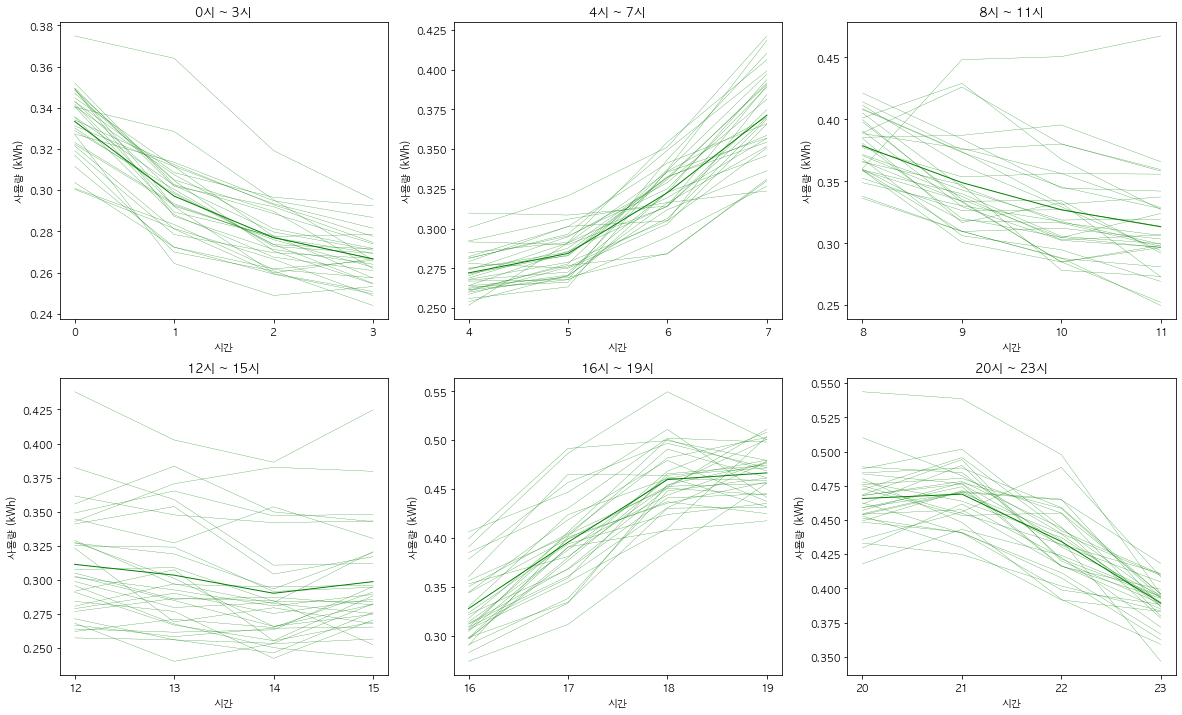

In [325]:
mean_time_group = time_group.mean(axis=1)

plt.figure(figsize=(20, 12))

for idx, group in enumerate(time_group):
    mean_group = mean_time_group[idx]
    start_time, end_time = times[idx]
    ax = plt.subplot(2, 3, idx+1)
    
    ax.plot(range(start_time,end_time + 1),group.T, color='g', linewidth=0.25)
    ax.plot(range(start_time,end_time + 1),mean_group, color='g', linewidth=1)
    ax.set_title("{}시 ~ {}시".format(start_time, end_time))
    plt.xticks(range(start_time,end_time + 1))
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

# 요일별 Grouping

In [280]:
def day_grouping(target, day_index):
    days = ['월', '화', '수', '목', '금', '토', '일']
    day_group = list()

    for idx, day in enumerate(days):
        day_group.append(target[
            day_index.weekday == idx].reshape(-1, 24))

    return day_group

In [281]:
target = time_clusters[2]
day_index = m_60.index

day_group = day_grouping(target, day_index)
day_group[0]

array([[0.5149411764705883, 0.4462058823529413, 0.4097058823529412,
        0.3913529411764705, 0.3689411764705883, 0.3975588235294118,
        0.5138235294117647, 0.5033235294117648, 0.6165294117647059,
        0.5156176470588235, 0.5202352941176471, 0.46744117647058825,
        0.5152058823529411, 0.45382352941176474, 0.44997058823529423,
        0.4611764705882353, 0.5170882352941176, 0.5628235294117648,
        0.6703529411764704, 0.6596764705882353, 0.6928823529411763,
        0.688529411764706, 0.6305588235294117, 0.5786764705882353],
       [0.4736176470588235, 0.4176176470588236, 0.38364705882352945,
        0.3589705882352941, 0.35267647058823537, 0.3586764705882354,
        0.5286176470588235, 0.5143529411764706, 0.488735294117647,
        0.4740294117647059, 0.5119411764705881, 0.5231176470588232,
        0.5726470588235293, 0.5161470588235294, 0.4817941176470588,
        0.4698529411764706, 0.49279411764705877, 0.5887352941176472,
        0.6775882352941175, 0.6303823529411

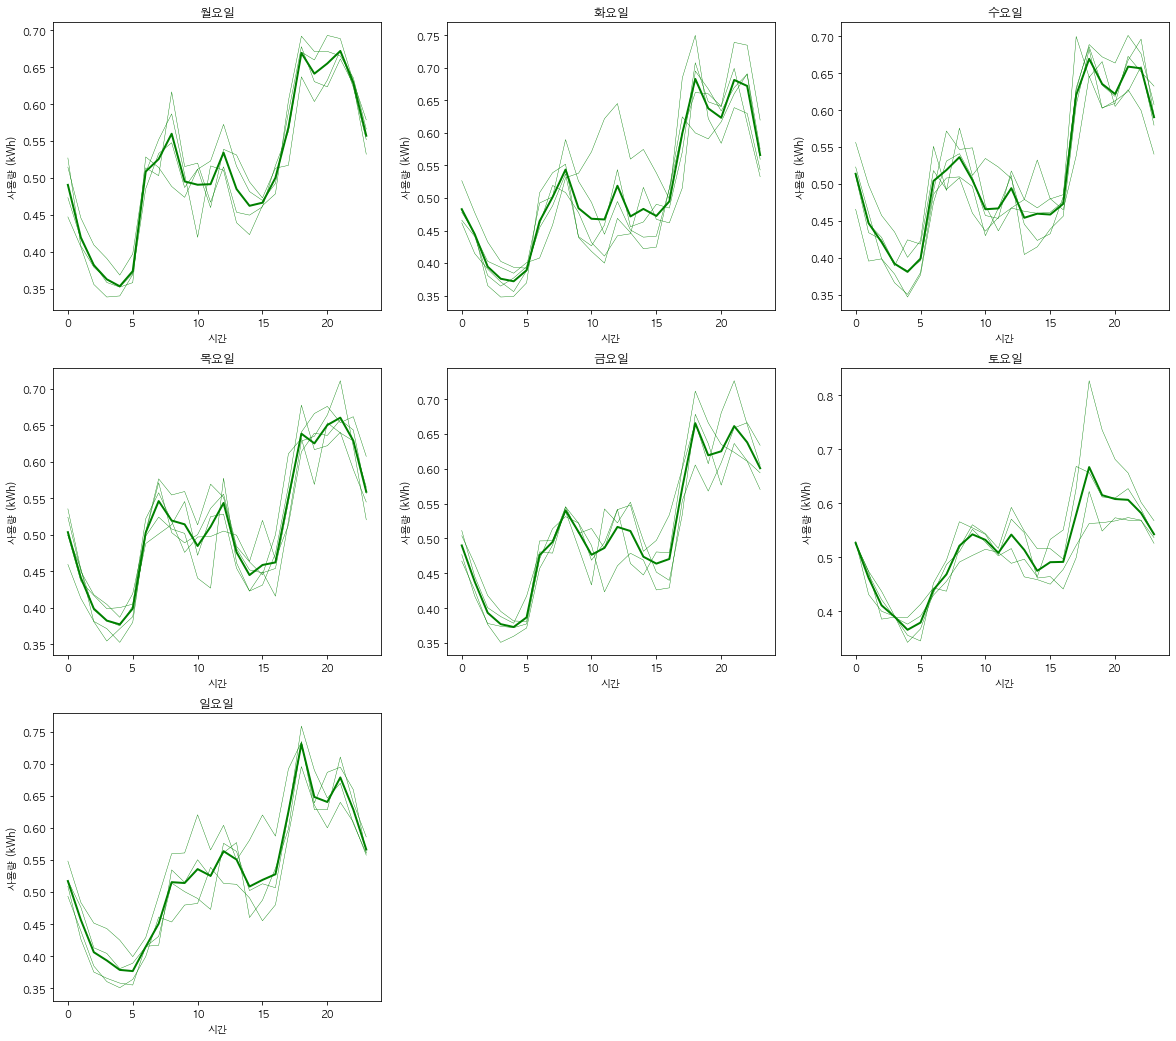

In [282]:
plt.figure(figsize=(20, 18))

for idx, group in enumerate(day_group):
    mean_group = group.mean(axis=0)
    day = days[idx]
    
    ax = plt.subplot(3, 3, idx+1)
    
    ax.plot(group.T, color='g', linewidth=0.4)
    ax.plot(mean_group, color='g', linewidth=2)
    ax.set_title("{}요일".format(day))
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

# 전기절약 피드백 예시

In [606]:
time_group

array([0.37491836734693884, 0.364081632653061, 0.31924489795918365,
       0.29548979591836727, 0.29216326530612247, 0.30589795918367346,
       0.31638775510204087, 0.32365306122448984, 0.3603265306122449,
       0.4482040816326531, 0.4506326530612244, 0.46732653061224483,
       0.4380204081632653, 0.4026326530612245, 0.38630612244897966,
       0.42471428571428577, 0.3853673469387755, 0.4306734693877551,
       0.5022244897959183, 0.4981836734693878, 0.5436530612244898,
       0.5386122448979592, 0.49773469387755115, 0.3958163265306122,
       0.34306122448979604, 0.3085714285714285, 0.2966122448979593,
       0.29244897959183674, 0.3005510204081633, 0.3206326530612244,
       0.3513061224489795, 0.4211428571428572, 0.4052040816326531,
       0.34551020408163263, 0.3166122448979591, 0.30628571428571433,
       0.32897959183673464, 0.2966530612244897, 0.2947142857142857,
       0.29597959183673467, 0.30487755102040814, 0.39063265306122447,
       0.4440408163265305, 0.478244897959183

In [619]:
sv.clusters

[array([[0.15439516129032257, 0.14466129032258063, 0.14152580645161292,
         0.1361516129032258],
        [0.13825, 0.14083870967741935, 0.155841935483871,
         0.16645967741935488],
        [0.1770951612903226, 0.16071290322580647, 0.14986774193548386,
         0.1470274193548387],
        [0.14320322580645165, 0.13765, 0.14299354838709674,
         0.14609032258064517],
        [0.15765, 0.18649516129032256, 0.22202096774193553,
         0.2319483870967742],
        [0.2194225806451613, 0.20598709677419358, 0.19395,
         0.17138387096774194]], dtype=object),
 array([[0.333442396313364, 0.2971586570111915, 0.27698354180381834,
         0.2666668861092824],
        [0.27212047399605, 0.2843739302172482, 0.3226352863726137,
         0.3713186306780777],
        [0.37868334430546424, 0.3489664252797894, 0.32701974983541804,
         0.31332455562870304],
        [0.3112639894667544, 0.30334891375905204, 0.2900414746543779,
         0.29859512837393026],
        [0.32815404871

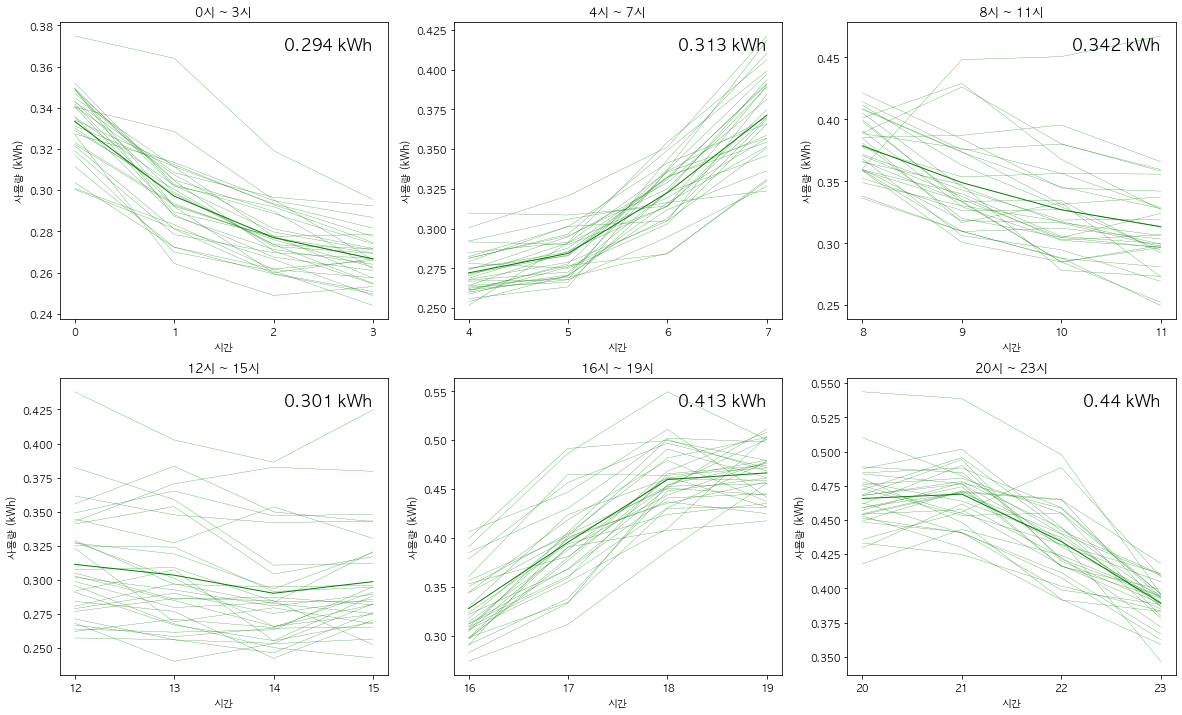

In [622]:
mean_time_group = sv.clusters[1]
time_group = time_clusters[1]

plt.figure(figsize=(20, 12))

for idx, group in enumerate(time_group):
    mean_group = group.mean(axis=0)
    start_time, end_time = times[idx]
    ax = plt.subplot(2, 3, idx+1)
    
    ax.plot(range(start_time,end_time + 1),group.T, color='g', linewidth=0.25)
    ax.plot(range(start_time,end_time + 1),mean_group, color='g', linewidth=1)
    ax.set_title("{}시 ~ {}시".format(start_time, end_time))
    ax.text(0.95, 0.95, 
            "{} kWh".format(round(mean_group.mean() * 1000) / 1000), 
            fontsize=16,
            ha="right",
            va="top",
            transform=ax.transAxes)
    plt.xticks(range(start_time,end_time + 1))
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

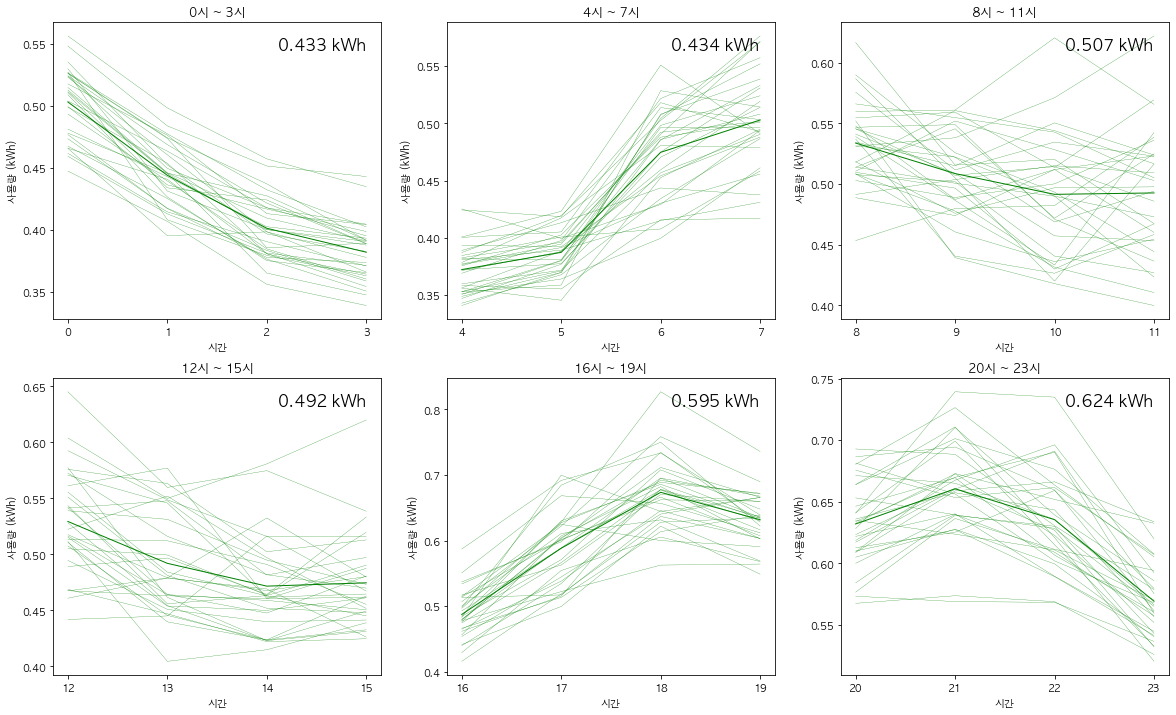

In [623]:
mean_time_group = sv.clusters[2]
time_group = time_clusters[2]

plt.figure(figsize=(20, 12))

for idx, group in enumerate(time_group):
    mean_group = mean_time_group[idx]
    start_time, end_time = times[idx]
    ax = plt.subplot(2, 3, idx+1)
    
    ax.plot(range(start_time,end_time + 1),group.T, color='g', linewidth=0.25)
    ax.plot(range(start_time,end_time + 1),mean_group, color='g', linewidth=1)
    ax.set_title("{}시 ~ {}시".format(start_time, end_time))
    ax.text(0.95, 0.95, 
            "{} kWh".format(round(mean_group.mean() * 1000) / 1000), 
            fontsize=16,
            ha="right",
            va="top",
            transform=ax.transAxes)
    plt.xticks(range(start_time,end_time + 1))
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

아파트1-103-1602


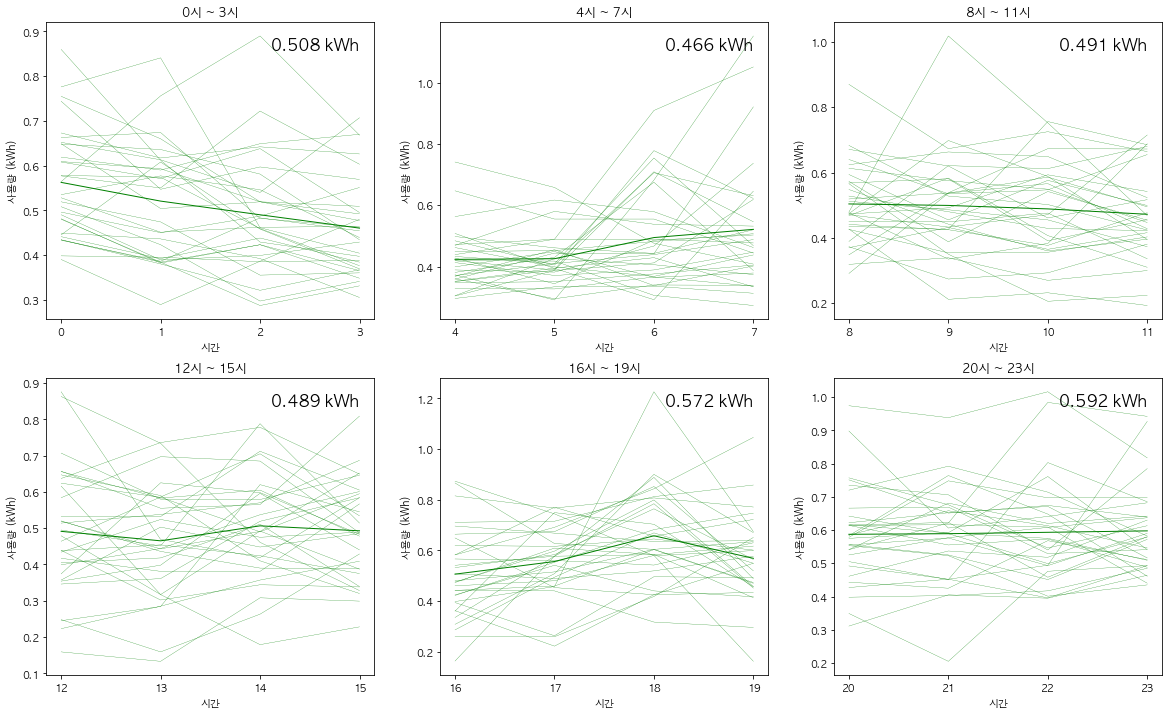

In [415]:
group_df = ut.make_group_df(m_60, kmeans)

target_household = group_df[group_df['label'] == 2].sample(n=1)['가구명'].values[0]

print(target_household)

target_house = m_60[target_household].values
house_time_group = time_grouping(target_house, 4)
house_time_group.shape

house_mean_time_group = house_time_group.mean(axis=1)

plt.figure(figsize=(20, 12))

for idx, group in enumerate(house_time_group):
    mean_group = house_mean_time_group[idx]
    start_time, end_time = times[idx]
    ax = plt.subplot(2, 3, idx+1)
    
    ax.plot(range(start_time,end_time + 1),group.T, color='g', linewidth=0.25)
    ax.plot(range(start_time,end_time + 1),mean_group, color='g', linewidth=1)
    ax.set_title("{}시 ~ {}시".format(start_time, end_time))
    ax.text(0.95, 0.95, 
            "{} kWh".format(round(mean_group.mean() * 1000) / 1000), 
            fontsize=16,
            ha="right",
            va="top",
            transform=ax.transAxes)
    plt.xticks(range(start_time,end_time + 1))
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

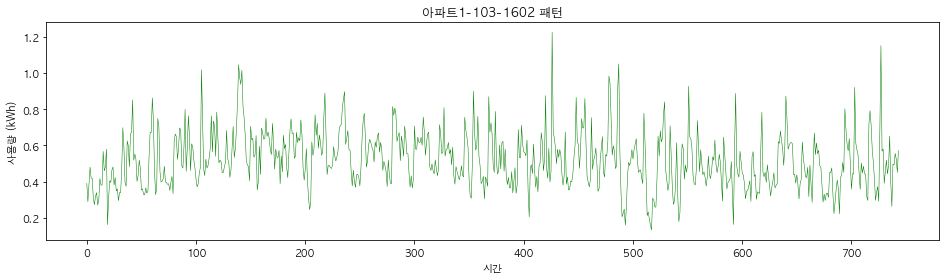

In [599]:
plt.figure(figsize=(16, 4))

plt.plot(target_house.flatten(), color='g', linewidth=0.5)
plt.title("{} 패턴".format('아파트1-103-1602'))
plt.ylabel("사용량 (kWh)")
plt.xlabel("시간")

plt.show()

In [600]:
target_household = group_df[group_df['가구명'] == '아파트1-103-1602']
target_household

,가구명,usage (kWh),label
11,아파트1-103-1602,387,2


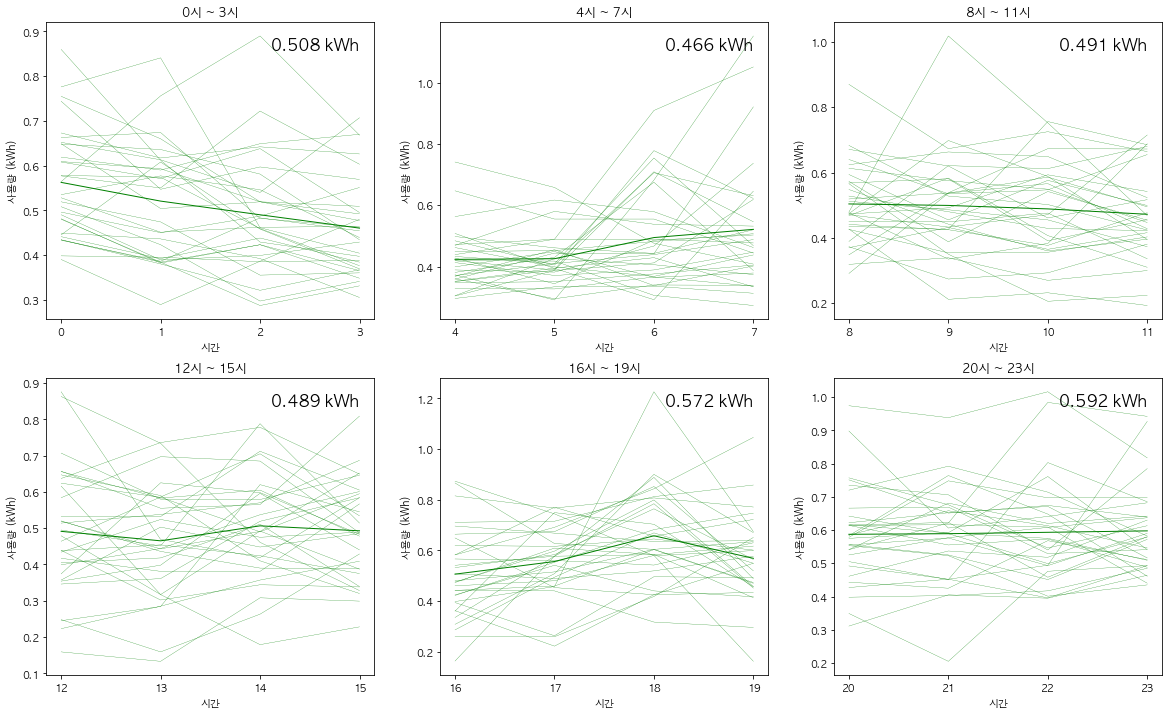

In [601]:
target_household = group_df[group_df['가구명'] == '아파트1-103-1602']['가구명']

target_house = m_60[target_household].values
house_time_group = time_grouping(target_house, 4)
house_time_group.shape

house_mean_time_group = house_time_group.mean(axis=1)

plt.figure(figsize=(20, 12))

for idx, group in enumerate(house_time_group):
    mean_group = house_mean_time_group[idx]
    start_time, end_time = times[idx]
    ax = plt.subplot(2, 3, idx+1)
    
    ax.plot(range(start_time,end_time + 1),group.T, color='g', linewidth=0.25)
    ax.plot(range(start_time,end_time + 1),mean_group, color='g', linewidth=1)
    ax.set_title("{}시 ~ {}시".format(start_time, end_time))
    ax.text(0.95, 0.95, 
            "{} kWh".format(round(mean_group.mean() * 1000) / 1000), 
            fontsize=16,
            ha="right",
            va="top",
            transform=ax.transAxes)
    plt.xticks(range(start_time,end_time + 1))
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

In [659]:
class SavingFeedback:
    def __init__(self, clusters):
        self.clusters = clusters
        
    def feedback(self, target, label):
        _mean_target = target.mean(axis=1)
        
        _now = (self.clusters[label].mean(axis=1) * 1000).astype(np.float).round() / 1000
        _prev = (self.clusters[label - 1].mean(axis=1) * 1000).astype(np.float).round() / 1000
        _target = (_mean_target.mean(axis=1) * 1000).astype(np.float).round() / 1000
        
        now_saving_point = np.where(_target > _now)[0]
        prev_saving_point = np.where(_target > _prev)[0]
        prev_saving_point = prev_saving_point[~np.isin(prev_saving_point, now_saving_point)]
        saving_point = np.sort(np.append(now_saving_point, prev_saving_point))
        
        err = np.zeros(all_saving_point.size)
        err[np.isin(all_saving_point, now_saving_point)] = _target[now_saving_point] - _now[now_saving_point]
        err[np.isin(all_saving_point, prev_saving_point)] = _target[prev_saving_point] - _prev[prev_saving_point]
        
        print(err)
        
        simulations = target.copy()

        for idx, sim in enumerate(simulations):
            sim -= all_err[idx]

            neg_err = sim[sim < 0]
            sim[sim < 0] = 0
            for neg in neg_err:
                sim[sim > abs(neg)][0] += neg

        return simulations

In [561]:
target_household

'아파트1-103-1602'

In [607]:
mean_time_clusters

[array([[0.15439516129032257, 0.14466129032258063, 0.14152580645161292,
         0.1361516129032258],
        [0.13825, 0.14083870967741935, 0.155841935483871,
         0.16645967741935488],
        [0.1770951612903226, 0.16071290322580647, 0.14986774193548386,
         0.1470274193548387],
        [0.14320322580645165, 0.13765, 0.14299354838709674,
         0.14609032258064517],
        [0.15765, 0.18649516129032256, 0.22202096774193553,
         0.2319483870967742],
        [0.2194225806451613, 0.20598709677419358, 0.19395,
         0.17138387096774194]], dtype=object),
 array([[0.333442396313364, 0.2971586570111915, 0.27698354180381834,
         0.2666668861092824],
        [0.27212047399605, 0.2843739302172482, 0.3226352863726137,
         0.3713186306780777],
        [0.37868334430546424, 0.3489664252797894, 0.32701974983541804,
         0.31332455562870304],
        [0.3112639894667544, 0.30334891375905204, 0.2900414746543779,
         0.29859512837393026],
        [0.32815404871

In [660]:
sv = SavingFeedback(clusters=mean_time_clusters)

In [661]:
house_mean_time_group

array([[0.5624516129032258, 0.5205806451612902, 0.48996774193548387,
        0.46012903225806445],
       [0.42348387096774187, 0.4256129032258065, 0.4945806451612904,
        0.5213225806451612],
       [0.5038709677419354, 0.4993225806451613, 0.48864516129032254,
        0.47219354838709676],
       [0.49125806451612897, 0.4651612903225807, 0.5064516129032258,
        0.49274193548387096],
       [0.5060645161290321, 0.555935483870968, 0.6575483870967741,
        0.5685483870967744],
       [0.5871612903225806, 0.5890000000000001, 0.5931612903225807,
        0.597483870967742]], dtype=object)

In [662]:
sims = sv.feedback(target=house_time_group, label=2)

[0.075 0.032 0.149 0.188 0.159 0.152]


In [416]:
now_c_mtg = (now_mean_time_group.mean(axis=1) * 1000).astype(np.float).round() / 1000
prev_c_mtg = (mean_time_group.mean(axis=1) * 1000).astype(np.float).round() / 1000
h_mtg = (house_mean_time_group.mean(axis=1) * 1000).astype(np.float).round() / 1000

In [417]:
now_saving_point = np.where(h_mtg > now_c_mtg)[0]
prev_saving_point = np.where(h_mtg > prev_c_mtg)[0]
prev_saving_point = prev_saving_point[~np.isin(prev_saving_point, now_saving_point)]

In [488]:
err_now = h_mtg[now_saving_point] - now_c_mtg[now_saving_point]
err_prev = h_mtg[prev_saving_point] - prev_c_mtg[prev_saving_point]

all_saving_point = np.sort(np.append(now_saving_point, prev_saving_point))
all_err = np.zeros(all_saving_point.size)

all_err

array([0., 0., 0., 0., 0., 0.])

In [489]:
all_err[np.isin(all_saving_point, now_saving_point)] = h_mtg[now_saving_point] - now_c_mtg[now_saving_point]
all_err[np.isin(all_saving_point, prev_saving_point)] = h_mtg[prev_saving_point] - prev_c_mtg[prev_saving_point]

all_err

array([0.075, 0.032, 0.149, 0.188, 0.159, 0.152])

In [566]:
simulations = house_time_group.copy()

for idx, sim in enumerate(simulations):
    sim -= all_err[idx]

    neg_err = sim[sim < 0]
    sim[sim < 0] = 0
    for neg in neg_err:
        sim[sim > abs(neg)][0] += neg
        
simulations.mean(axis=1).mean(axis=1)

array([0.43328225806451615, 0.4342499999999999, 0.3420080645161291,
       0.30188709677419356, 0.41302419354838715, 0.43970161290322574],
      dtype=object)

In [571]:
simulations[0].mean(axis=0)

array([0.48745161290322575, 0.4455806451612904, 0.41496774193548386,
       0.3851290322580644], dtype=object)

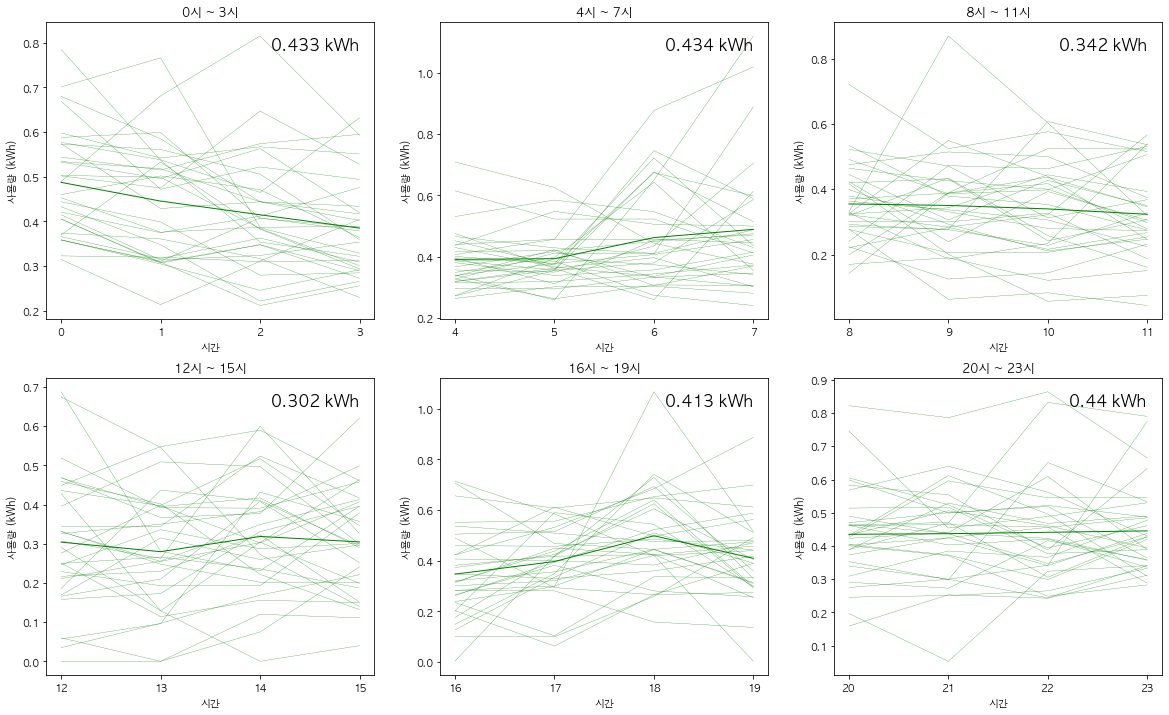

In [656]:
plt.figure(figsize=(20, 12))

for idx, group in enumerate(sims):
    mean_group = group.mean(axis=0)
    start_time, end_time = times[idx]
    ax = plt.subplot(2, 3, idx+1)
    
    ax.plot(range(start_time,end_time + 1),group.T, color='g', linewidth=0.25)
    ax.plot(range(start_time,end_time + 1),mean_group, color='g', linewidth=1)
    ax.set_title("{}시 ~ {}시".format(start_time, end_time))
    ax.text(0.95, 0.95, 
            "{} kWh".format(round(mean_group.mean() * 1000) / 1000), 
            fontsize=16,
            ha="right",
            va="top",
            transform=ax.transAxes)
    plt.xticks(range(start_time,end_time + 1))
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

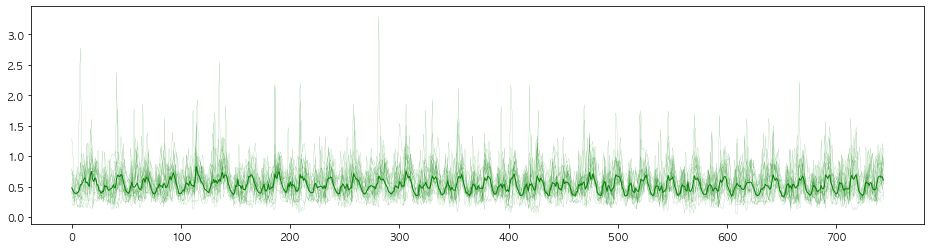

In [651]:
plt.figure(figsize=(16, 4))

chk_df = group_df[group_df['label'] == 2].copy()
chk_np = m_60[chk_df['가구명']].to_numpy()
chk_cluster = kmeans.clusters_[2]

plt.plot(chk_np.T[chk_np.sum(axis=0) > chk_cluster.sum()].T, color='g', linewidth=0.1)
plt.plot(chk_cluster, color='g', linewidth=1)

plt.show()

In [ ]:
plt.figure(figsize=(16, 4))

plt.plot(chk_np.T[chk_np.sum(axis=0) > chk_cluster.sum()].T, color='g', linewidth=0.1)
plt.plot(chk_cluster, color='g', linewidth=1)

plt.show()

In [658]:
sims.shape

(6, 31, 4)

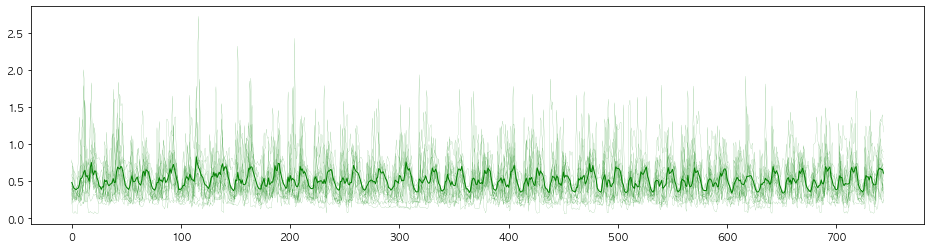

In [652]:
plt.figure(figsize=(16, 4))

chk_df = group_df[group_df['label'] == 2].copy()
chk_np = m_60[chk_df['가구명']].to_numpy()
chk_cluster = kmeans.clusters_[2]

plt.plot(chk_np.T[chk_np.sum(axis=0) < chk_cluster.sum()].T, color='g', linewidth=0.1)
plt.plot(chk_cluster, color='g', linewidth=1)

plt.show()

In [663]:
target_house.sum()

386.65299999999985

In [664]:
simulations.sum()

293.15500000000003

In [580]:
group_df[group_df['가구명'] == target_household]

,가구명,usage (kWh),label
11,아파트1-103-1602,387,2


In [473]:
sims = house_time_group[prev_saving_point[1]] - err_prev[1]
neg_err = sims[sims < 0]
sims[sims < 0] = 0

sims

array([[0.22900000000000004, 0.19300000000000006, 0.193,
        0.37900000000000006],
       [0.186, 0.437, 0.4100000000000001, 0.295],
       [0.675, 0.546, 0.27299999999999996, 0.14],
       [0.3960000000000001, 0.5090000000000001, 0.49700000000000005,
        0.299],
       [0.246, 0.336, 0.287, 0.301],
       [0.27599999999999997, 0.39799999999999996, 0.5169999999999999,
        0.34600000000000003],
       [0.16600000000000004, 0.20999999999999996, 0.408, 0.252],
       [0.46800000000000014, 0.39499999999999996, 0.417, 0.29],
       [0.056999999999999995, 0.09599999999999997, 0.432,
        0.35700000000000004],
       [0.326, 0.35000000000000003, 0.38200000000000006,
        0.49900000000000005],
       [0.449, 0.548, 0.5900000000000001, 0.461],
       [0.332, 0.248, 0.20199999999999996, 0.201],
       [0.5190000000000001, 0.39200000000000007, 0.39100000000000007,
        0.458],
       [0.46900000000000003, 0.36700000000000005, 0.37700000000000006,
        0.621],
       [0.459

In [475]:
for neg in neg_err:
    sims[sims > abs(neg)][0] += neg

In [476]:
sims.mean()

0.3018870967741934

In [701]:
round(sims.sum())

293

In [698]:
idx = month_df[month_df['name'] == '아파트1-103-1602'].index
month_df.loc[idx]['usage (kWh)'] = round(sims.sum())

In [706]:
month_df.iloc[idx, 1] = round(sims.sum())

In [707]:
month_df[month_df['name'] == '아파트1-103-1602']

,name,usage (kWh)
63,아파트1-103-1602,293


In [708]:
calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )

In [709]:
calc.households[idx[0]].elec_bill

29826

63